# Ejercicio 4
Implemente un modelo de difusión para la generación de imágenes de señales de transito de 28 x 28.

[Enlace a Github](https://github.com/rodrygo-c-garcia/IA_2/blob/main/PrimerParcial/Ejercicio4_MD.ipynb)

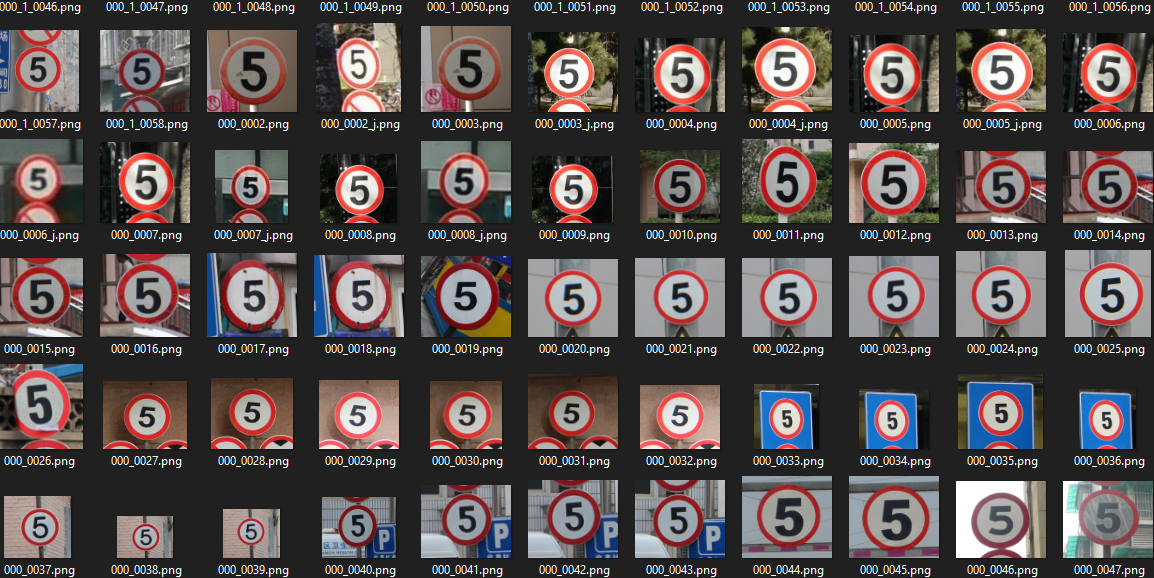

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import ImageFolder

# ruta donde se encuentra el dataset
dataset_path = '/content/drive/MyDrive/Data/Transito'

# cargando el dataset usando ImageFolder
dataset = ImageFolder(dataset_path)

# transformaciones a aplicar a las imágenes
transform = transforms.Compose([      
    transforms.Resize((28,28)),      
    transforms.RandomRotation(degrees=15),      
    transforms.RandomHorizontalFlip(),      
    transforms.ToTensor() ])

# aplicando las transformaciones al dataset
dataset_transformed = ImageFolder(dataset_path, transform=transform)


In [ ]:
len(dataset_transformed)

5998

# Visualisacion de los Datos

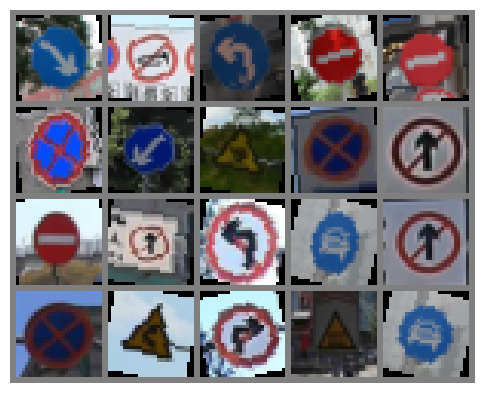

In [ ]:
import random
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# seleccionar 20 imágenes aleatorias
random_indices = random.sample(range(len(dataset_transformed)), 20)
images = [dataset_transformed[i][0] for i in random_indices]

# mostrar imágenes en una grilla más pequeña
grid = make_grid(images, nrow=5, scale_each=True, pad_value=0.5)
plt.figure(figsize=(6, 6))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()


# Difusion Hacia Adelante

In [ ]:
import torch.nn.functional as F

Se define una función **linear_beta_schedule** que toma el número de pasos de tiempo y los valores inicial y final de los coeficientes beta, y devuelve un tensor con los valores linealmente espaciados entre el inicio y el final.

In [ ]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
  # Devuelve un tensor con valores (beta) linealmente espaciados entre el inicio y el final
  return torch.linspace(start, end, timesteps)

Define una función **get_index_from_list** que toma una lista de valores, un tensor con los índices deseados y la forma de la imagen original, y devuelve los valores correspondientes a los índices teniendo en cuenta la dimensión del lote. vals se refiere a los valores que se utilizan para guiar el proceso de difusión hacia adelante, y estos valores pueden variar según la aplicación.
Los valores de la raíz cuadrada de uno menos alfa y la raíz cuadrada recíproca de alfa para un tiempo específico t en el proceso de difusión hacia adelante.

In [ ]:
def get_index_from_list(vals, t, x_shape):
  """ 
  Devuelve un índice específico t de una lista de valores vals
  considerando la dimensión del lote.
  """
  batch_size = t.shape[0] # Obtiene el tamaño del lote a partir del tensor de índices
  out = vals.gather(-1, t.cpu()) # Obtiene los valores correspondientes a los índices usando la función gather
  return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device) # Reajusta los valores para que coincidan con la forma de la imagen y los envía al dispositivo

# Funcion para Difuminar la Imagen
Define una función **forward_diffusion_sample** que toma una imagen original, un paso de tiempo y el dispositivo a usar, y devuelve la versión ruidosa de la imagen usando la fórmula cerrada del algoritmo de difusión hacia adelante. También devuelve el ruido añadido a la imagen.

In [ ]:
def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Toma una imagen y un paso de tiempo como entrada y 
    devuelve la versión ruidosa de la misma
    """
    noise = torch.randn_like(x_0) # Genera un tensor de ruido con la misma forma que la imagen
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape) # Obtiene el valor de sqrt_alphas_cumprod para el paso de tiempo dado, son los productos acumulados de las raíces cuadradas de α y 1−α
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape) # Obtiene el valor de sqrt_one_minus_alphas_cumprod para el paso de tiempo dado
    # media + varianza
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device) # Aplica la fórmula cerrada para obtener la imagen ruidosa y devuelve también el ruido

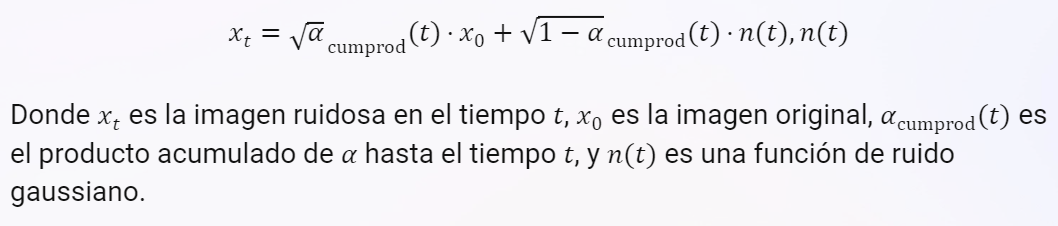

In [ ]:
# Define la secuencia beta
T = 300 # Número de pasos de tiempo
betas = linear_beta_schedule(timesteps=T) # Obtiene los valores de beta usando la función definida anteriormente

# Pre-calcula diferentes términos para la fórmula cerrada
alphas = 1. - betas # Calcula los valores de alfa restando beta a uno
alphas_cumprod = torch.cumprod(alphas, axis=0) # Calcula el producto acumulado de los alfas a lo largo del eje 0
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0) # Añade un valor 1 al principio del tensor alfas_cumprod y elimina el último valor
sqrt_recip_alphas = torch.sqrt(1.0 / alphas) # Calcula la raíz cuadrada inversa de los alfas
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod) # Calcula la raíz cuadrada directa de los alfas_cumprod
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod) # Calcula la raíz cuadrada directa de uno menos los alfas_cumprod
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod) # Calcula la varianza posterior usando los términos anteriores

Define las constantes IMG_SIZE y BATCH_SIZE para el tamaño de las imágenes y el tamaño del lote respectivamente.

In [ ]:
from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 28 # Tamaño de las imágenes
BATCH_SIZE = 128 # Tamaño del lote

# Carga de los datos
Define una función load_transformed_dataset que carga y transforma el conjunto de datos de StanfordCars. Las transformaciones que aplica son:

In [ ]:
def load_transformed_dataset():
    # Define una lista de transformaciones para aplicar a las imágenes
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)), # Redimensiona las imágenes a 28 x 28
        transforms.RandomHorizontalFlip(), # Aplica un volteo horizontal aleatorio
        transforms.ToTensor(), # Convierte las imágenes a tensores y escala los valores al rango [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Escala los valores al rango [-1, 1] 
    ]
    # Crea una transformación compuesta con la lista anterior
    data_transform = transforms.Compose(data_transforms)

    # Carga el conjunto de datos de entrenamiento y prueba desde la ruta especificada utilizando ImageFolder
    dataset_transformed = ImageFolder(dataset_path, transform=transform)

    # Devuelve un conjunto de datos concatenado con los datos de entrenamiento y prueba
    return dataset_transformed


Define una función show_tensor_image que toma un tensor de imagen y lo muestra usando matplotlib.pyplot. La función aplica las transformaciones inversas a las que se usaron para cargar el conjunto de datos,

In [ ]:
def show_tensor_image(image):
    # Define una lista de transformaciones inversas para mostrar la imagen original
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2), # Escala los valores al rango [0, 1]
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # Permuta los ejes del tensor a HWC
        transforms.Lambda(lambda t: t * 255.), # Multiplica los valores por 255
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)), # Convierte el tensor a numpy y cambia el tipo a uint8
        transforms.ToPILImage(), # Convierte el tensor a una imagen PIL
    ])

    # Toma la primera imagen del lote si el tensor tiene 4 dimensiones
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    # Muestra la imagen usando matplotlib.pyplot
    plt.imshow(reverse_transforms(image))

In [ ]:
# Carga y transforma el conjunto de datos de StanfordCars usando la función definida anteriormente
data = load_transformed_dataset()
# Crea un DataLoader con el conjunto de datos, el tamaño del lote, el parámetro shuffle y el parámetro drop_last
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [ ]:
len(data)

5998

<ipython-input-75-08df968cdc47>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1) # Crea un subplot para mostrar la imagen


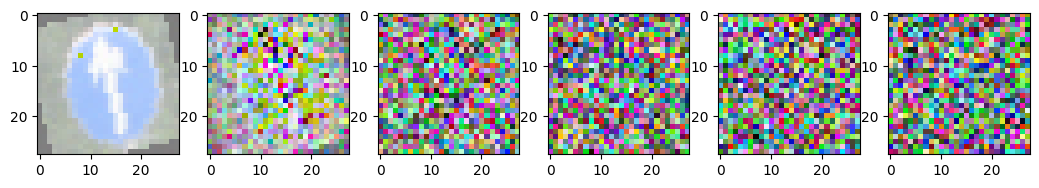

In [ ]:
# Simula la difusión hacia adelante
image = next(iter(dataloader))[0] # Obtiene una imagen del DataLoader

plt.figure(figsize=(15,15)) # Crea una figura con matplotlib.pyplot
plt.axis('off') # Oculta los ejes
num_images = 6 # Número de imágenes a mostrar
stepsize = int(T/num_images) # Tamaño del paso entre cada imagen

for idx in range(0, T, stepsize): # Itera sobre los pasos de tiempo
    t = torch.Tensor([idx]).type(torch.int64) # Crea un tensor con el valor del paso de tiempo actual
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1) # Crea un subplot para mostrar la imagen
    image, noise = forward_diffusion_sample(image, t) # Aplica la función forward_diffusion_sample a la imagen
    show_tensor_image(image) # Muestra la imagen ruidosa

# Difusion hacia atras = U-Net

La clase Block aprende a reconstruir una imagen a partir de una imagen ruidosa y una incrustación de tiempo. El bloque puede hacer upsampling o downsampling de la imagen dependiendo del argumento up que se le pase al constructor.

In [ ]:
from torch import nn
import math

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        # Capa de tiempo MLP, lo transforma en otro vector de la misma dimensión que el número de canales de salida del bloque.
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        # Capas convolucionales
        if up: # codificador y del decodificador.
            #  aumentar el número de píxeles de la imagen
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            # reducir el número de píxeles de la imagen
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)

        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        # Capas de normalización
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        # Función de activación ReLU
        self.relu  = nn.ReLU()
        
    def forward(self, x, t):
        # Primera convolución
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Incrustación de tiempo
        time_emb = self.relu(self.time_mlp(t))
        # Extender la última 2 dimensiones
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Agregar canal de tiempo
        h = h + time_emb
        # Segunda convolución
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Upsampling o downsampling
        return self.transform(h)


Esta clase crea un vector que indica en qué momento se generó la imagen ruidosa. Este vector ayuda al modelo a recuperar la imagen original quitando el ruido.

Se llama así porque usa funciones sinusoidales (seno y coseno) para generar el vector a partir del tiempo. También se llama así porque el vector es una incrustación (embedding), es decir, una representación de baja dimensión de una información de alta dimensión. Finalmente, se llama así porque el vector representa la posición (position) de la imagen ruidosa en la secuencia de difusión.



In [ ]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim # Guarda la dimensión de las incrustaciones como un atributo

    def forward(self, time):
        device = time.device # Obtiene el dispositivo del tensor de tiempo
        half_dim = self.dim // 2 # Calcula la mitad de la dimensión de las incrustaciones
        embeddings = math.log(10000) / (half_dim - 1) # Calcula el factor de escala para las frecuencias
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings) # Calcula las frecuencias exponenciales decrecientes
        embeddings = time[:, None] * embeddings[None, :] # Multiplica el tiempo por las frecuencias para obtener los argumentos de las funciones seno y coseno
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1) # Aplica las funciones seno y coseno y concatena los resultados a lo largo del último eje
        # TODO: Double check the ordering here
        return embeddings # Devuelve el tensor de incrustaciones posicionales sinusoidales
        # es una forma de representar la posición de cada elemento en una secuencia como un vector numérico

In [ ]:
# Esta es la clase que define el modelo U-Net
class SimpleUnet(nn.Module):

    def __init__(self):
        # Esta es la función que inicializa el modelo
        super().__init__()
        # Estos son los parámetros del modelo
        image_channels = 3 # Número de canales de la imagen de entrada
        down_channels = (16, 32, 64) # Número de canales de salida de cada bloque del codificador
        up_channels = (64, 32, 16) # Número de canales de salida de cada bloque del decodificador
        out_dim = 3 # Número de canales de la imagen de salida
        time_emb_dim = 32 # Dimensión del vector que representa el paso temporal

        # Incrustación temporal (time embedding)
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim), # Esta capa genera una representación sinusoidal del paso temporal
                nn.Linear(time_emb_dim, time_emb_dim), # Esta capa aplica una transformación lineal al vector anterior
                nn.ReLU() # Esta capa aplica una función de activación ReLU al vector resultante
            )
        
        # Proyección inicial
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1) # Esta capa aplica una convolución 2D a la imagen de entrada con un kernel de tamaño 3x3 y un relleno (padding) de 1 píxel

        # Muestreo ascendente (upsample)
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)]) # Esta lista contiene los bloques del decodificador, que se definen más abajo como una clase aparte y tienen un argumento adicional para indicar que son bloques ascendentes
        
        # Muestreo descendente (downsample)
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)]) # Esta lista contiene los bloques del codificador, que se definen más abajo como una clase aparte
        
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1) # Esta capa aplica una convolución 2D al mapa de características final con un kernel de tamaño 1x1 para obtener la imagen de salida

    def forward(self, x, timestep):
        # Esta es la función que define el paso hacia adelante (forward pass) del modelo
        # Recibe como argumentos la imagen de entrada x y el paso temporal timestep
        # Devuelve la imagen de salida y
        
        # Incrustar el tiempo
        t = self.time_mlp(timestep) # Esta línea aplica la capa de incrustación temporal definida anteriormente al paso temporal y obtiene el vector t
        
        # Conv inicial
        x = self.conv0(x) # Esta línea aplica la capa de convolución inicial definida anteriormente a la imagen de entrada x y obtiene el mapa de características x
        
        # U-Net
        residual_inputs = [] # Esta lista va a almacenar los mapas de características del codificador que se van a usar como conexiones residuales
        for down in self.downs: # Este bucle recorre los bloques del codificador
            x = down(x, t) # Esta línea aplica el bloque del codificador al mapa de características x y al vector t y obtiene el nuevo mapa de características x
            residual_inputs.append(x) # Esta línea añade el mapa de características x a la lista de conexiones residuales
        for up in self.ups: # Este bucle recorre los bloques del decodificador
            residual_x = residual_inputs.pop() # Esta línea extrae el último mapa de características de la lista de conexiones residuales y lo asigna a la variable residual_x
            # Añadir residual x como canales adicionales
            x = torch.cat((x, residual_x), dim=1) # Esta línea concatena el mapa de características x y el mapa residual_x a lo largo del eje de los canales, obteniendo un nuevo mapa de características x           
            x = up(x, t) # Esta línea aplica el bloque del decodificador al mapa de características x y al vector t y obtiene el nuevo mapa de características x
        return self.output(x) # Esta línea aplica la capa de salida definida anteriormente al mapa de características final x y devuelve la imagen de salida y

In [ ]:
# Esta es la línea que crea una instancia del modelo U-Net
model = SimpleUnet()
# Esta es la línea que imprime el número de parámetros del modelo
print("Num params: ", sum(p.numel() for p in model.parameters()))
# Esta es la línea que imprime el modelo
model

Num params:  236435


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=32, bias=True)
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=64, bias=True)
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(

In [ ]:
# Define una función que calcula la pérdida de un modelo de difusión hacia adelante
def get_loss(model, x_0, t):
    # Usa la función forward_diffusion_sample para generar una imagen ruidosa y el ruido correspondiente a partir de una imagen original y un paso de tiempo
    x_noisy, noise = forward_diffusion_sample(x_0, t, device='cuda')
    # Usa el modelo para predecir el ruido a partir de la imagen ruidosa y el paso de tiempo
    noise_pred = model(x_noisy, t)
    # Calcula la pérdida como la diferencia absoluta media entre el ruido real y el predicho
    return F.l1_loss(noise, noise_pred)

La función **sample_timestep** toma como argumentos una imagen x y un paso de tiempo t, y devuelve una imagen generada por un modelo de difusión.

In [ ]:
# Define una función que genera una imagen para un paso de tiempo dado usando un modelo de difusión hacia atrás
@torch.no_grad() # Usa el decorador para indicar que no se necesita calcular los gradientes
def sample_timestep(x, t):

    # Obtiene los valores de los parámetros beta, sqrt_one_minus_alphas_cumprod y sqrt_recip_alphas para el paso de tiempo t usando la función get_index_from_list
    betas_t = get_index_from_list(betas, t, x.shape)

    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )

    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    # Estos parámetros son necesarios para calcular la media y la varianza de la distribución posterior condicional del modelo de difusión.
    
    # Llama al modelo para predecir el ruido a partir de la imagen actual y el paso de tiempo
    # Calcula la media del modelo como una combinación lineal de la imagen actual y la predicción del ruido
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    # Obtiene el valor de la varianza posterior para el paso de tiempo t usando la función get_index_from_list
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    # Si el paso de tiempo es cero, devuelve la media del modelo como la imagen generada
    if t == 0:
        return model_mean
    # Si no, genera un ruido aleatorio con la misma forma que la imagen y lo escala por la raíz cuadrada de la varianza posterior
    # Suma el ruido escalado a la media del modelo y devuelve el resultado como la imagen generada
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

La función **sample_plot_image** tiene como objetivo generar y mostrar una imagen a partir de un ruido aleatorio usando un modelo de difusión hacia atrás.

In [ ]:
# Define una función que genera y muestra una imagen a partir de un ruido aleatorio usando un modelo de difusión hacia atrás
@torch.no_grad() # Usa el decorador para indicar que no se necesita calcular los gradientes

def sample_plot_image():
    # Crea una variable llamada img_size que almacena el tamaño de la imagen deseada
    img_size = IMG_SIZE
    # Crea un tensor llamado img que contiene valores aleatorios con la forma (1, 3, img_size, img_size) y lo asigna al dispositivo (GPU o CPU) que se está usando
    img = torch.randn((1, 3, img_size, img_size), device=device)
    # Crea una figura de matplotlib con un tamaño de 15x15 pulgadas y desactiva los ejes
    plt.figure(figsize=(15,15))
    plt.axis('off')
    # Crea una variable llamada num_images que indica el número de imágenes que se van a mostrar
    num_images = 10
    # Crea una variable llamada stepsize que indica el intervalo de tiempo entre cada imagen generada
    stepsize = int(T/num_images)

    # Usa un bucle for para recorrer los valores de 0 a T (un parámetro global que indica el número total de pasos de tiempo) en orden inverso
    for i in range(0,T)[::-1]:
        # Dentro del bucle, crea un tensor llamado t que contiene el valor actual del paso de tiempo y lo asigna al dispositivo
        t = torch.full((1,), i, device=device, dtype=torch.long)
        # Usa una función llamada sample_timestep que toma como argumentos el tensor img y el tensor t y devuelve una nueva imagen generada por el modelo para ese paso de tiempo
        img = sample_timestep(img, t)
        # Usa la función torch.clamp para limitar los valores del tensor img entre -1.0 y 1.0
        img = torch.clamp(img, -1.0, 1.0)
        # Si el valor actual del paso de tiempo es divisible por el valor de stepsize, muestra la imagen generada en un subplot de la figura usando la función show_tensor_image que convierte el tensor img en una imagen de PIL y la muestra con plt.imshow
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    # Al final del bucle, muestra la figura completa con plt.show
    plt.show()       

# Entrenamiento

Epoch 0 | step 000 Loss: 0.8187653422355652 


<ipython-input-82-ee1e8fbe69b3>:26: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


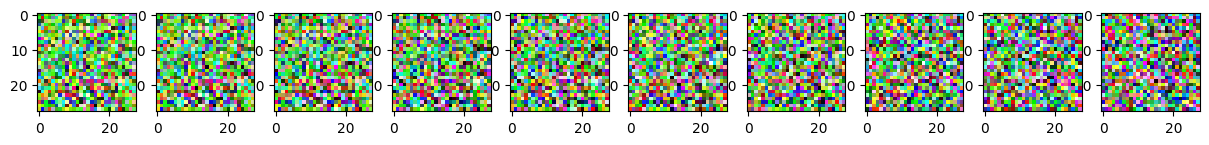

Epoch 5 | step 000 Loss: 0.21782974898815155 


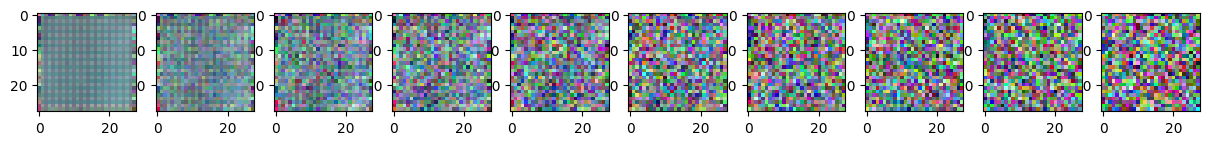

Epoch 10 | step 000 Loss: 0.18881765007972717 


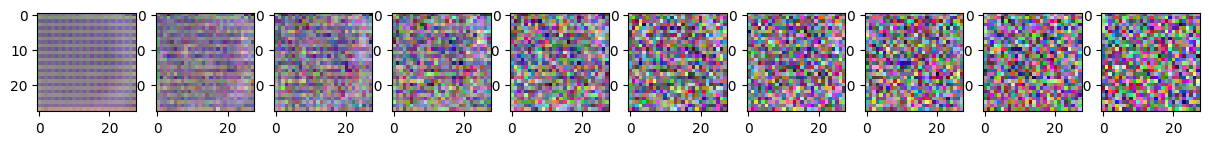

Epoch 15 | step 000 Loss: 0.1766664832830429 


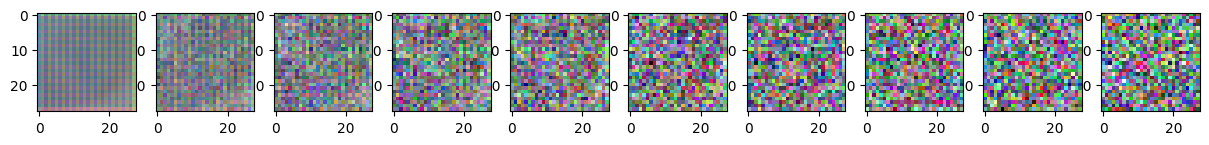

Epoch 20 | step 000 Loss: 0.1822066307067871 


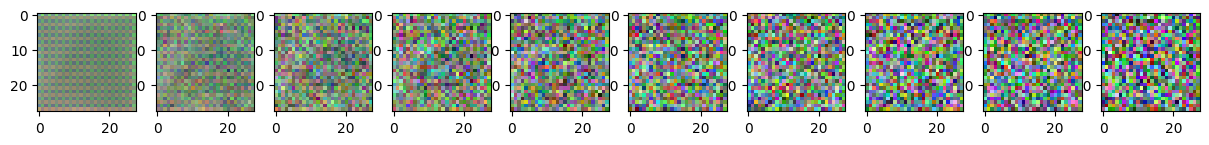

Epoch 25 | step 000 Loss: 0.15857858955860138 


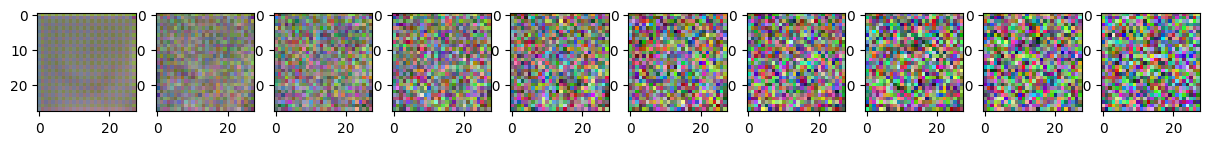

Epoch 30 | step 000 Loss: 0.164869025349617 


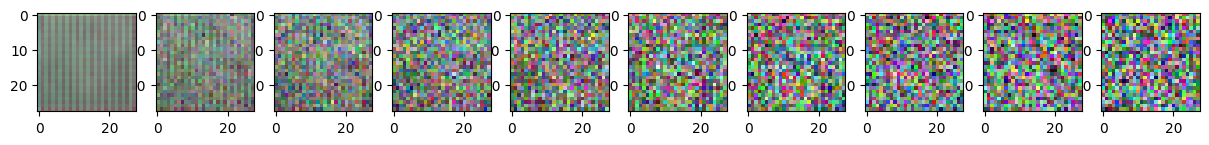

Epoch 35 | step 000 Loss: 0.14181862771511078 


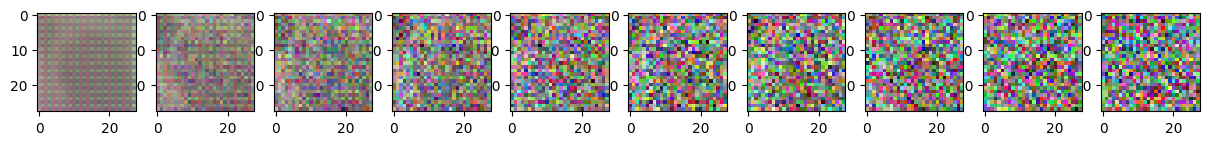

Epoch 40 | step 000 Loss: 0.1782882660627365 


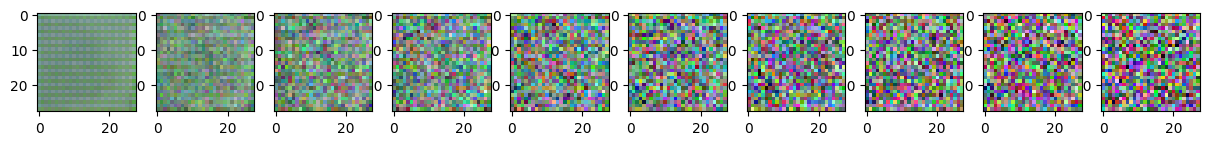

Epoch 45 | step 000 Loss: 0.1411009579896927 


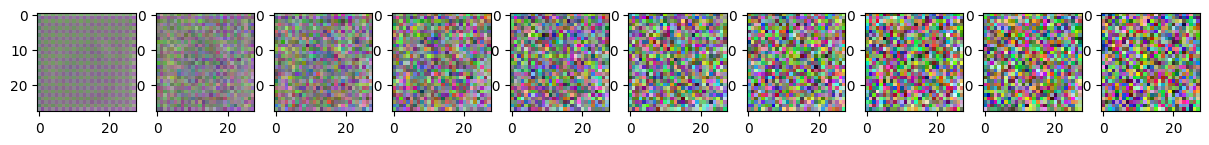

Epoch 50 | step 000 Loss: 0.1463925540447235 


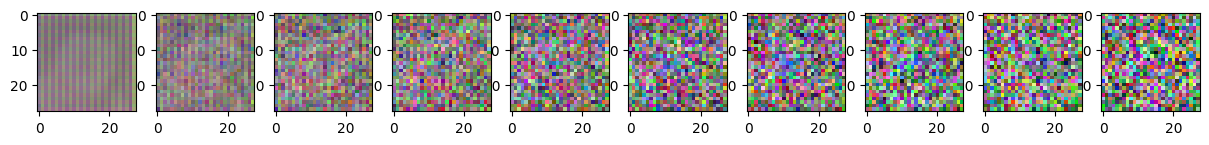

Epoch 55 | step 000 Loss: 0.16091027855873108 


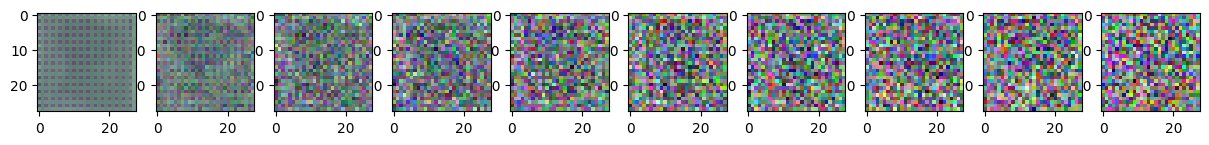

Epoch 60 | step 000 Loss: 0.13489103317260742 


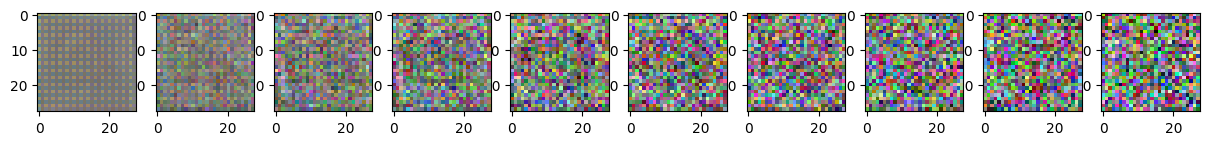

Epoch 65 | step 000 Loss: 0.15396623313426971 


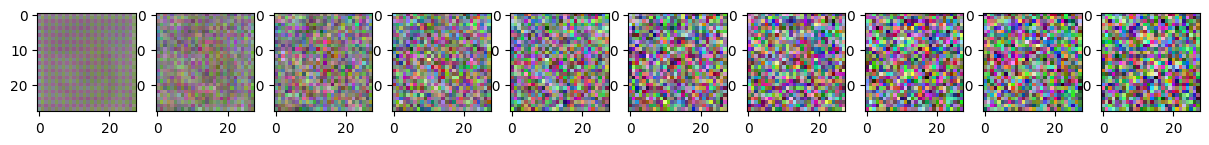

Epoch 70 | step 000 Loss: 0.13553756475448608 


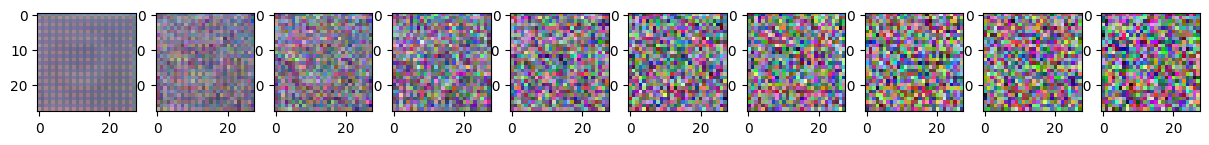

Epoch 75 | step 000 Loss: 0.1457175612449646 


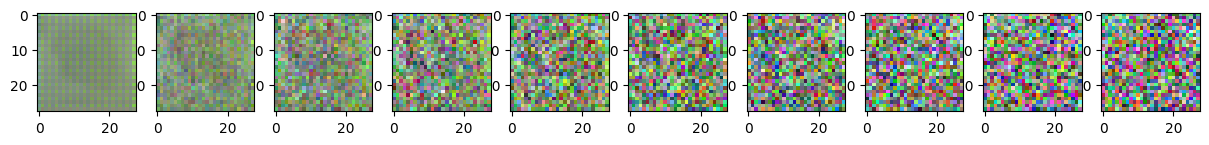

Epoch 80 | step 000 Loss: 0.1328633576631546 


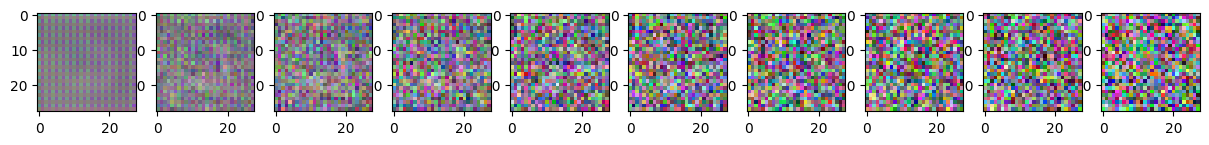

Epoch 85 | step 000 Loss: 0.14315447211265564 


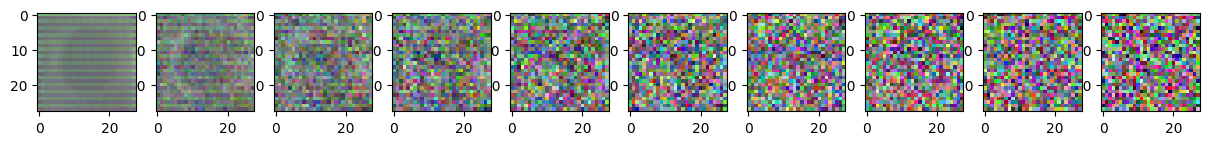

Epoch 90 | step 000 Loss: 0.13160116970539093 


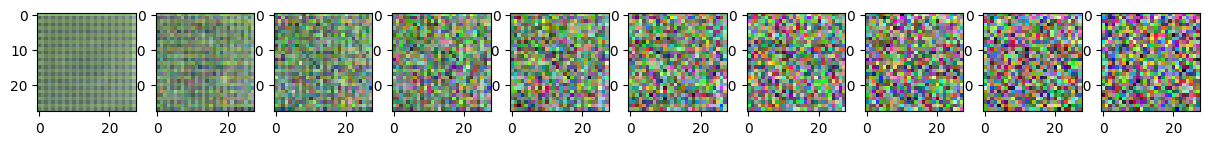

Epoch 95 | step 000 Loss: 0.1506400853395462 


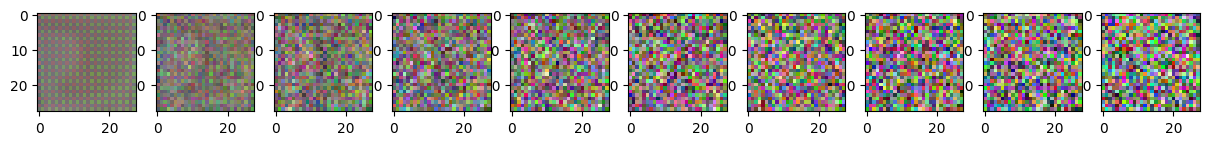

In [ ]:
# Importa la clase Adam del módulo torch.optim
from torch.optim import Adam

# Verifica si hay una GPU disponible y asigna el valor "cuda" o "cpu" a la variable device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Crea un objeto de la clase Adam que tomará como argumentos los parámetros del modelo, la tasa de aprendizaje (lr) y otras opciones específicas del algoritmo
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100 

# Usa un bucle for para recorrer las épocas desde 0 hasta epochs - 1
for epoch in range(epochs):
    # Dentro del bucle de las épocas, usa otro bucle for para recorrer los lotes (batch) del dataloader
    for step, batch in enumerate(dataloader):
      # Dentro del bucle de los lotes, usa el método zero_grad del optimizador para poner a cero los gradientes de los parámetros del modelo
      optimizer.zero_grad()

      # Crea un tensor llamado t que contiene valores enteros aleatorios entre 0 y T - 1 con la forma (BATCH_SIZE,) y lo asigna al dispositivo
      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      # Usa la función get_loss que definimos anteriormente para calcular la pérdida del modelo para el lote actual y el tensor t
      loss = get_loss(model, batch[0], t)
      # Usa el método backward de la pérdida para calcular los gradientes de los parámetros del modelo con respecto a la pérdida
      loss.backward()
      # Usa el método step del optimizador para actualizar los parámetros del modelo usando los gradientes calculados
      optimizer.step()

      # Si la época actual es múltiplo de 5 y el paso actual es cero, imprime el valor de la época, el paso y la pérdida
      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        # Usa la función sample_plot_image que definimos anteriormente para generar y mostrar una imagen usando el modelo entrenado
        sample_plot_image()